In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from hybrid_model_v3 import HybridSegModel
from helper import postprocess_logits_with_fill

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F

In [2]:
# image_size = 128
# inference_name = "hybrid_model_ge(nodule_gland)_benq(gland)_from_scratch_v1_aug_space(0.9)"
# # inference_name = "from_scratch"
# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"../../code/models/finetune/ge_benq/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to("cuda")

In [3]:
image_size = 128

inference_name = "hybrid_model_ge(nodule_gland_inference)_benq(gland)_from_scratch_v2_aug_space(0.9)_weight_decay(1e-5)"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"../../code/models/from_scratch/ge_benq_inference/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

model.to("cuda")

HybridSegModel(
  (backbone): HarDNetBackbone(
    (base_conv_1): ConvLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_conv_2): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (hardblock): HarDBlock(
          (layers): ModuleList(
            (0): ConvLayer(
              (conv): Conv2d(64, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (norm): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [4]:
image_dir = os.listdir("crop_images/")
print(len(image_dir))

110


# inference all videos

In [ ]:
data_root = "crop_images"
video_dir = os.listdir(data_root)
for video_name in tqdm(video_dir):

    print(video_name)
    image_dir = sorted(os.listdir(f"{data_root}/{video_name}"))
    image_dir = sorted(image_dir, key=lambda x: int(x.split('.')[0]))
    print(len(image_dir))
    count = 0
    for i in (range(len(image_dir))):
        image_name = image_dir[i]
        if not "png" in image_name:
            continue
        image_path = f"{data_root}/{video_name}/{image_name}"
        image = Image.open(image_path).convert("L")
    
        resize = T.Resize((image_size, image_size))
        image = resize(image)
    
        image_tensor = tx.to_tensor(image)
        # If standardization
        mean = image_tensor.mean()
        std = image_tensor.std()
        std = std if std > 0 else 1.0  # avoid division by zero
        image_tensor = (image_tensor - mean) / std
        image = image_tensor.unsqueeze(0)
        image = image.to("cuda")
        output = model(image)
        
        nodule_output = output[:, 0:1]
        gland_output = output[:, 1:2]
    
        # nodule_output = torch.sigmoid(nodule_output)
        nodule_process = postprocess_logits_with_fill(nodule_output, 0.9)
        
        nodule_output = torch.sigmoid(nodule_output)
        nodule_output = nodule_output > 0.99
    
        gland_output = postprocess_logits_with_fill(gland_output, 0.9)
        gland_output = gland_output > 0.99
        
        # print(gland_output.shape)
    
        nodule_image = Image.fromarray(nodule_output[0][0].detach().cpu().numpy())
        gland_image = Image.fromarray(gland_output[0][0].detach().cpu().numpy())
        
        
    
        video_path = f"inference_mask_from_scratch_v1/{video_name}/"
        nodule_path = f"inference_mask_from_scratch_v1/{video_name}/nodule/"
        gland_path = f"inference_mask_from_scratch_v1/{video_name}/gland/"
        combine_nodule_path = f"inference_mask_from_scratch_v1/{video_name}/combine_nodule/"
        combine_gland_path = f"inference_mask_from_scratch_v1/{video_name}/combine_gland/"
        
        # if not os.path.exists(nodule_path):
        os.makedirs(video_path, exist_ok=True)
        os.makedirs(nodule_path, exist_ok=True)
        os.makedirs(gland_path, exist_ok=True)
        os.makedirs(combine_nodule_path, exist_ok=True)
        os.makedirs(combine_gland_path, exist_ok=True)
            
        # nodule_image.save(nodule_path + image_name)
        # gland_image.save(gland_path + image_name)
    
        plt.imshow(image[0][0].detach().cpu().numpy())
        plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.3)
        plt.axis('off')
        # plt.savefig(f"{combine_nodule_path}/{image_name}", bbox_inches='tight', pad_inches=0)
        # plt.show()
        plt.close()
    
        plt.imshow(image[0][0].detach().cpu().numpy())
        plt.imshow(gland_output[0][0].detach().cpu().numpy(), alpha = 0.3)
        plt.axis('off')
        # plt.savefig(f"{combine_gland_path}/{image_name}", bbox_inches='tight', pad_inches=0)
        # plt.show()
        plt.close()
        # break
        if count%5 == 0:
            print(video_name + "/" + image_name)
            plt.figure(figsize = (20, 20))
            plt.subplot(1,5,1)
            plt.imshow(image[0][0].detach().cpu().numpy())
            plt.title("image")
            plt.subplot(1,5,2)
            plt.imshow(nodule_output[0][0].detach().cpu().numpy())
            plt.title("nodule pred")
            
            plt.subplot(1,5,3)
            plt.imshow(image[0][0].detach().cpu().numpy())
            plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.5)
            plt.title("nodule on image")
            
            plt.subplot(1,5,4)
            plt.imshow(nodule_process[0][0].detach().cpu().numpy())
            plt.title("nodule processed")
            plt.subplot(1,5,5)
            plt.imshow(gland_output[0][0].detach().cpu().numpy())
            plt.title("gland pred")
            plt.show()
        count+=1
        # if count > 30:
        #     break
    # break

# inference one video

video_000041_1734078135266.MP4
186
video_000041_1734078135266.MP4/0.png


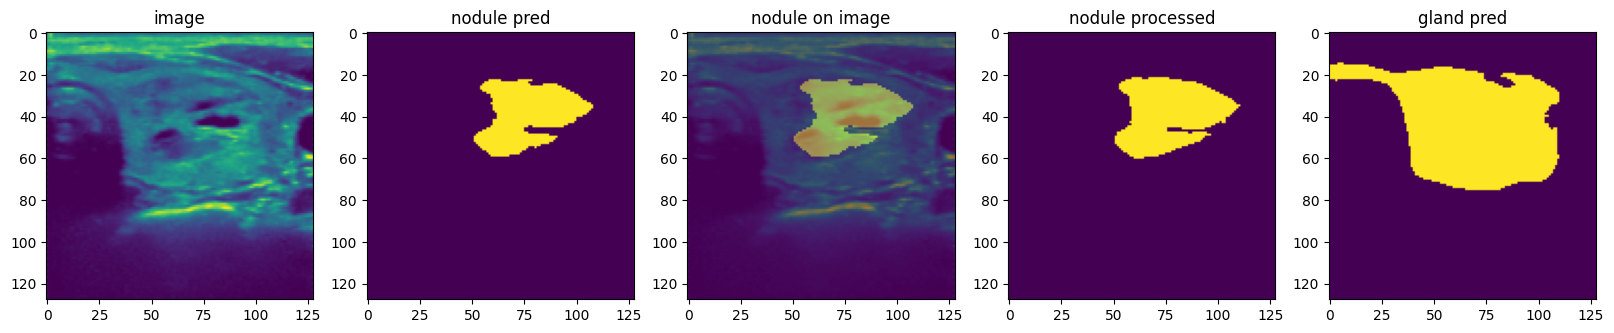

video_000041_1734078135266.MP4/5.png


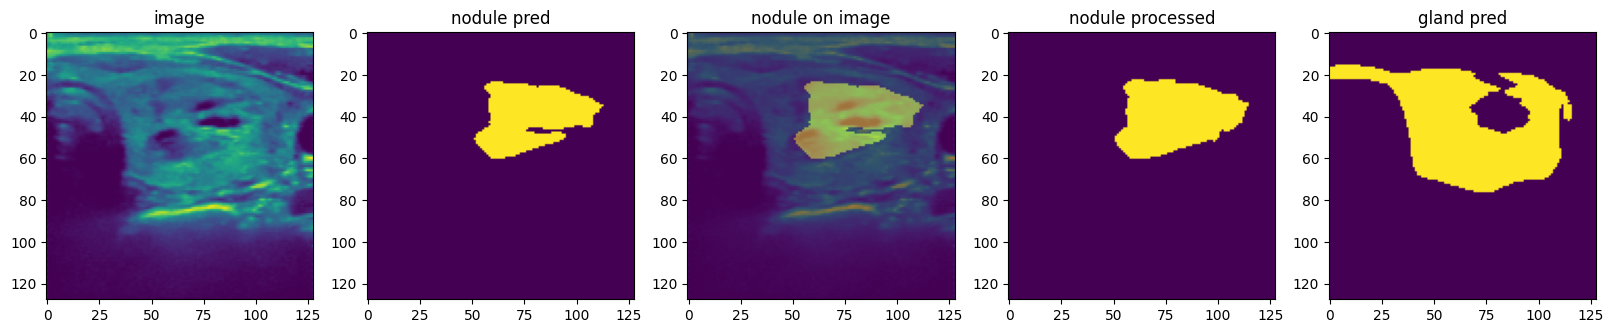

video_000041_1734078135266.MP4/10.png


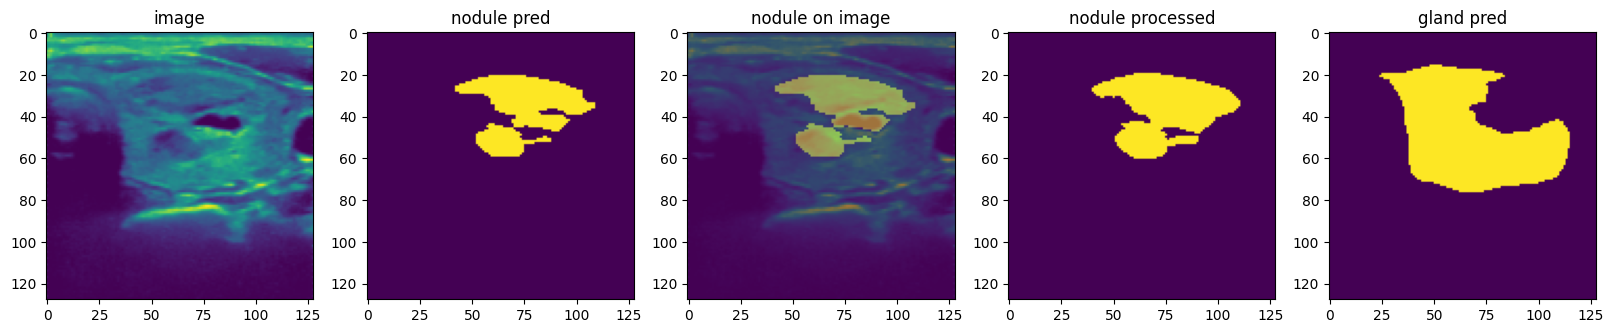

video_000041_1734078135266.MP4/15.png


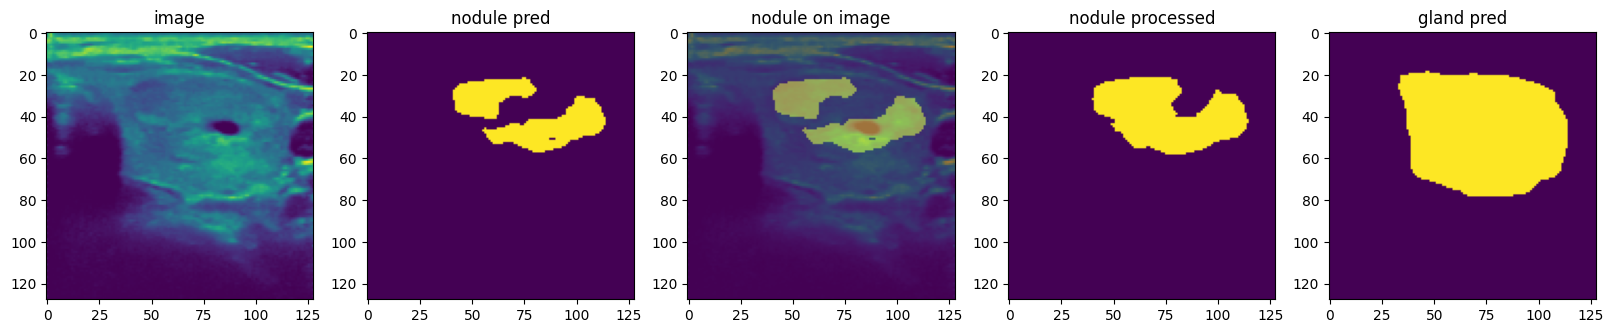

video_000041_1734078135266.MP4/20.png


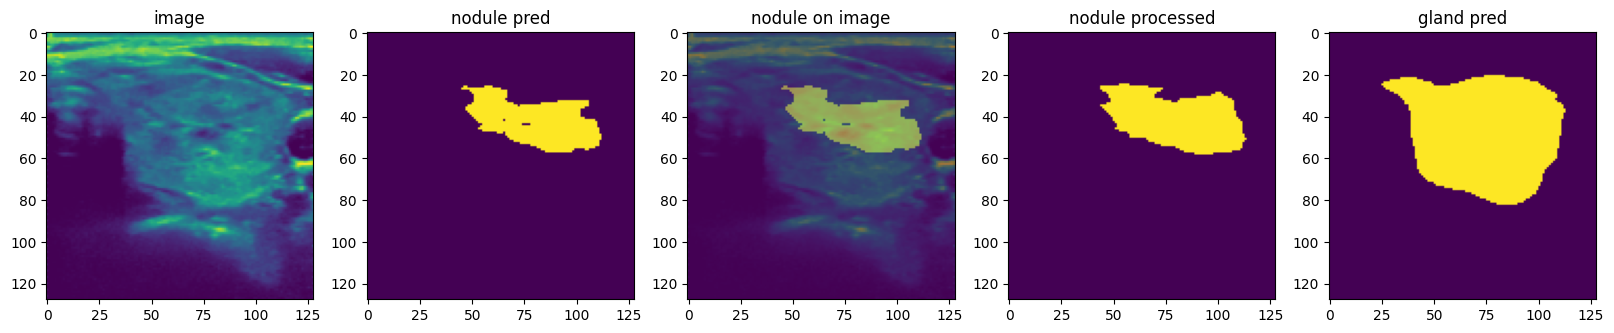

video_000041_1734078135266.MP4/25.png


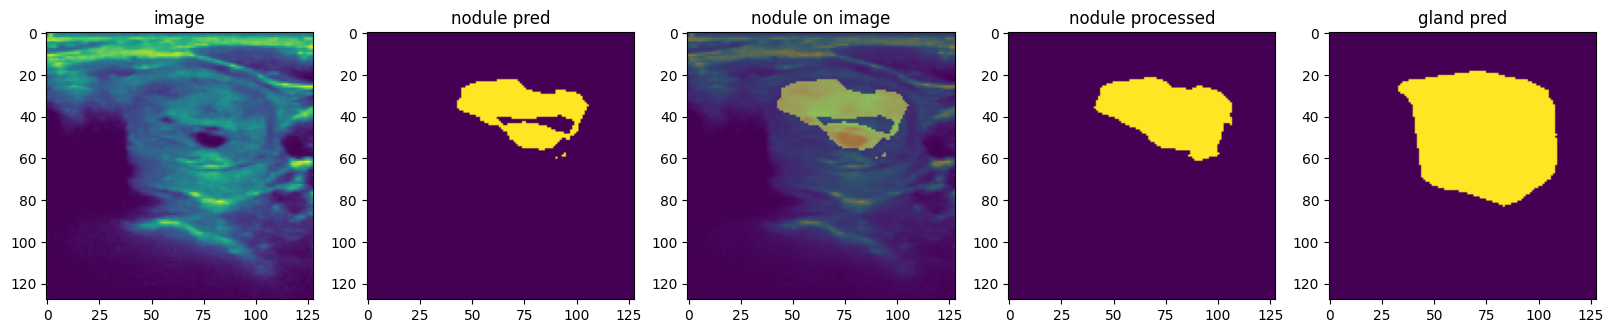

video_000041_1734078135266.MP4/30.png


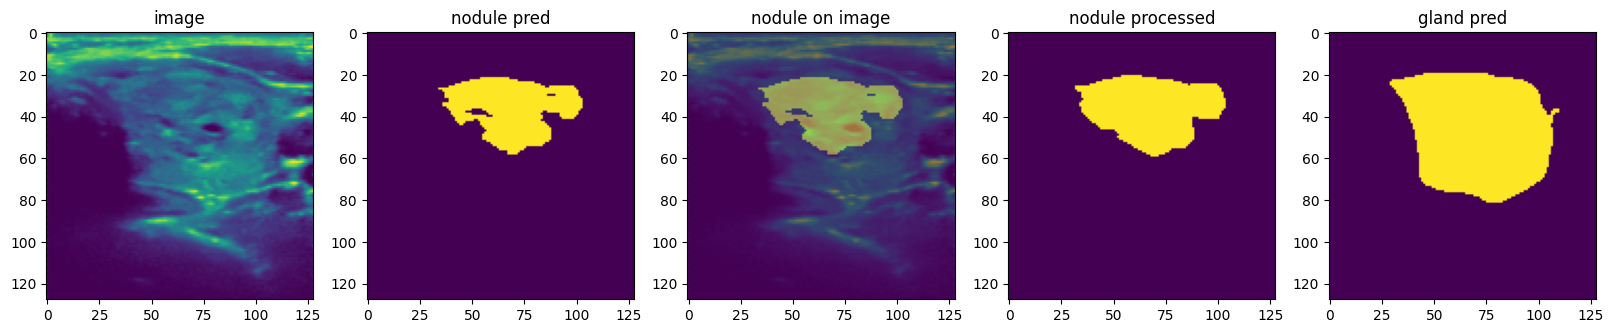

video_000041_1734078135266.MP4/35.png


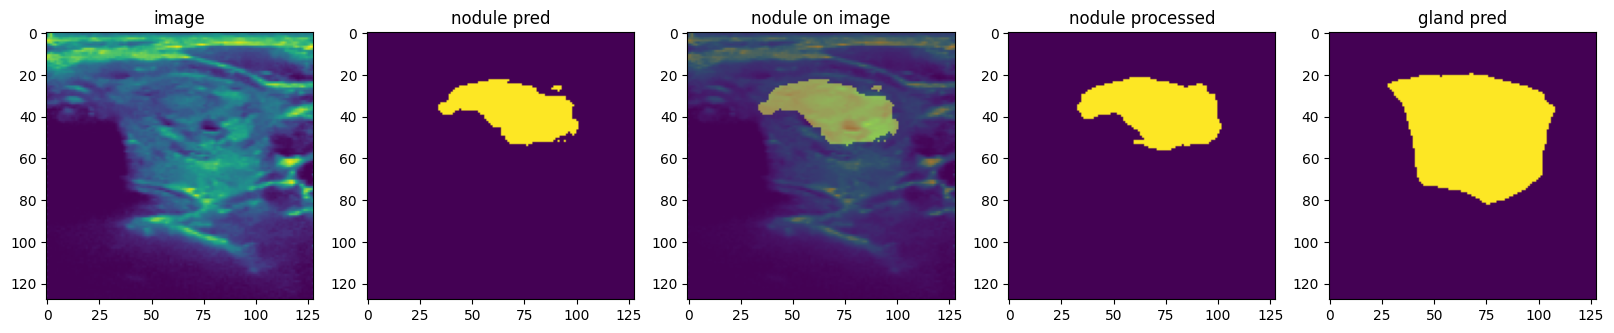

video_000041_1734078135266.MP4/40.png


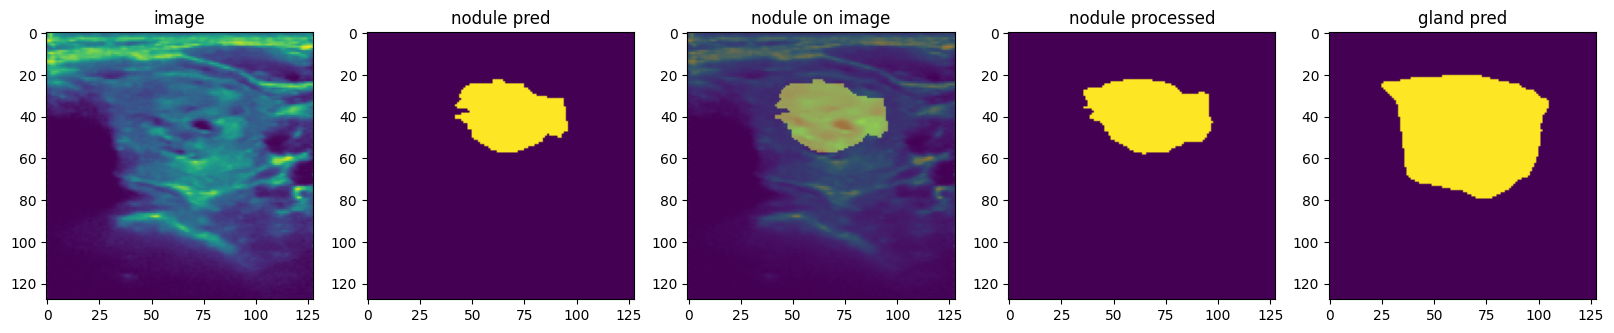

video_000041_1734078135266.MP4/45.png


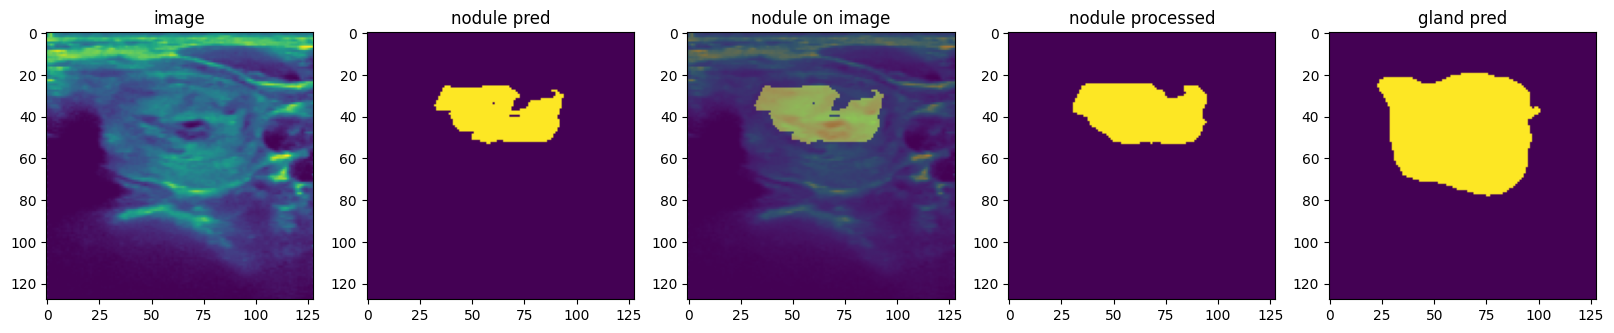

video_000041_1734078135266.MP4/50.png


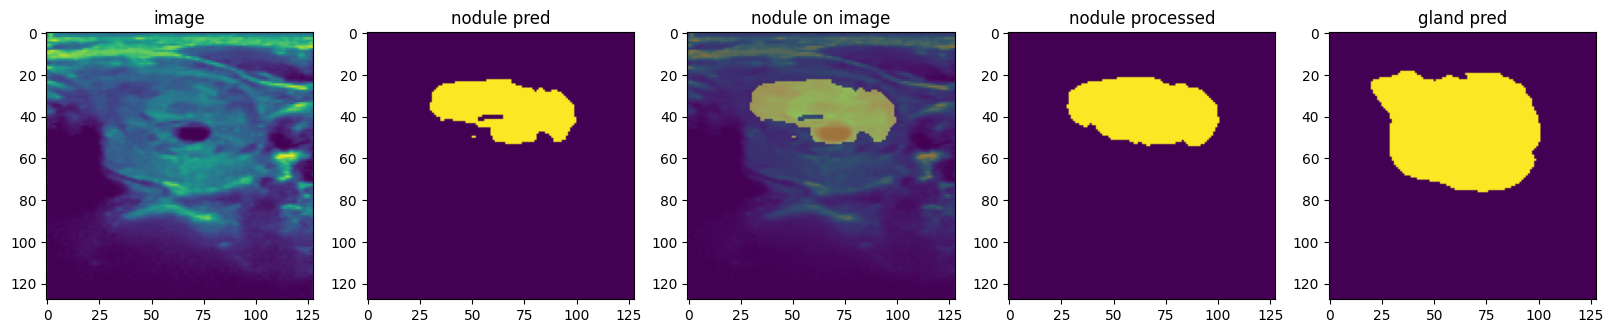

video_000041_1734078135266.MP4/55.png


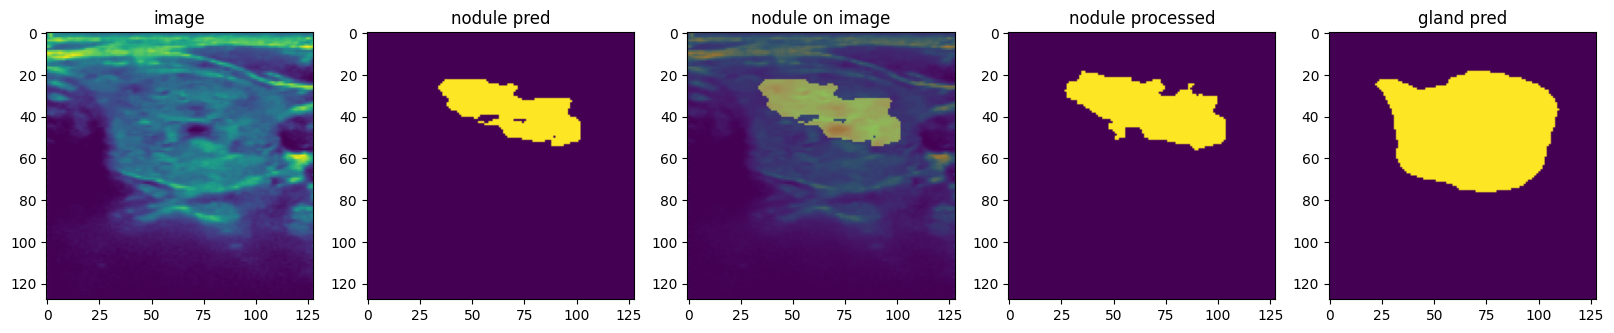

video_000041_1734078135266.MP4/60.png


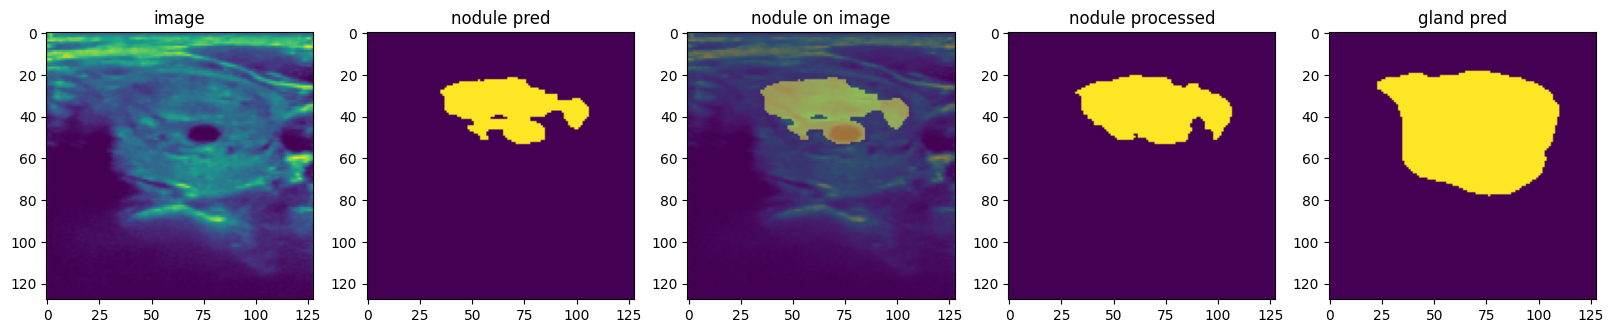

video_000041_1734078135266.MP4/65.png


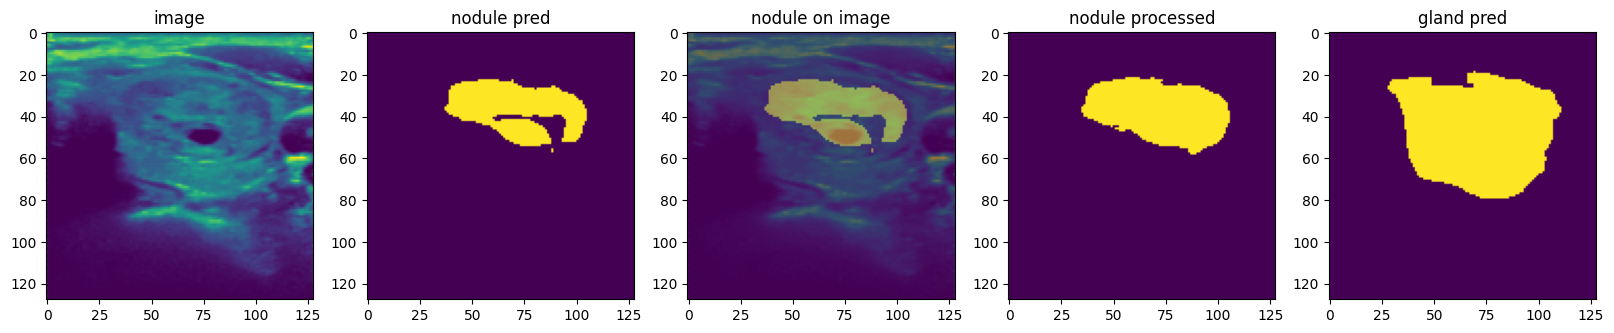

video_000041_1734078135266.MP4/70.png


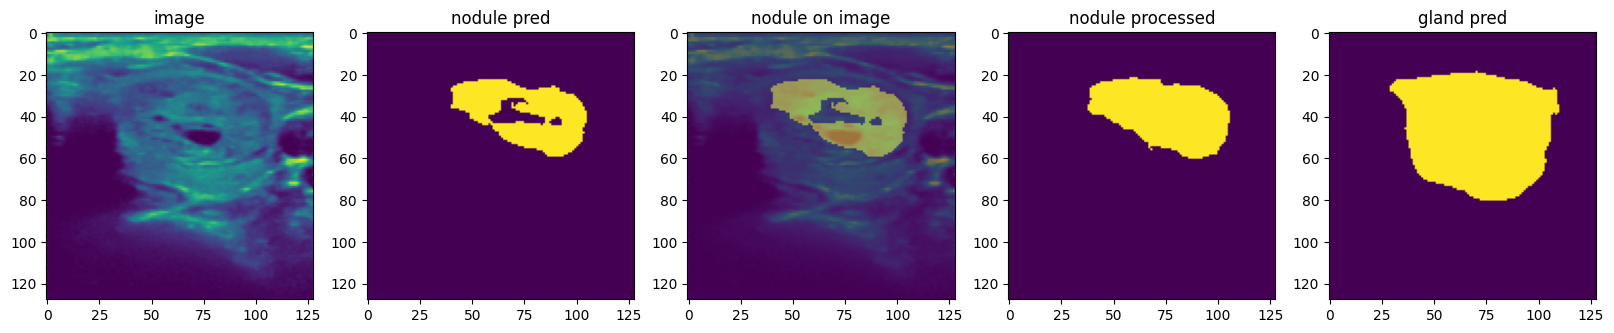

video_000041_1734078135266.MP4/75.png


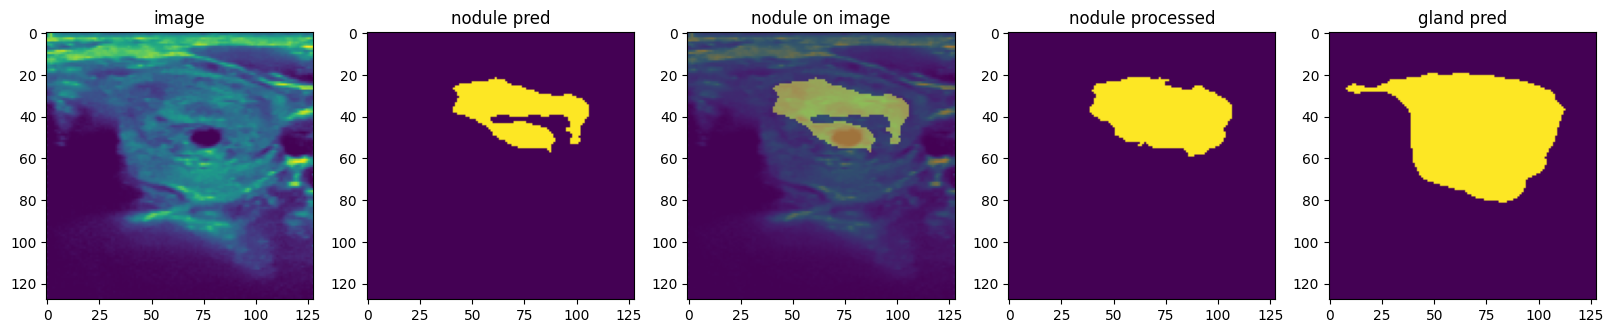

video_000041_1734078135266.MP4/80.png


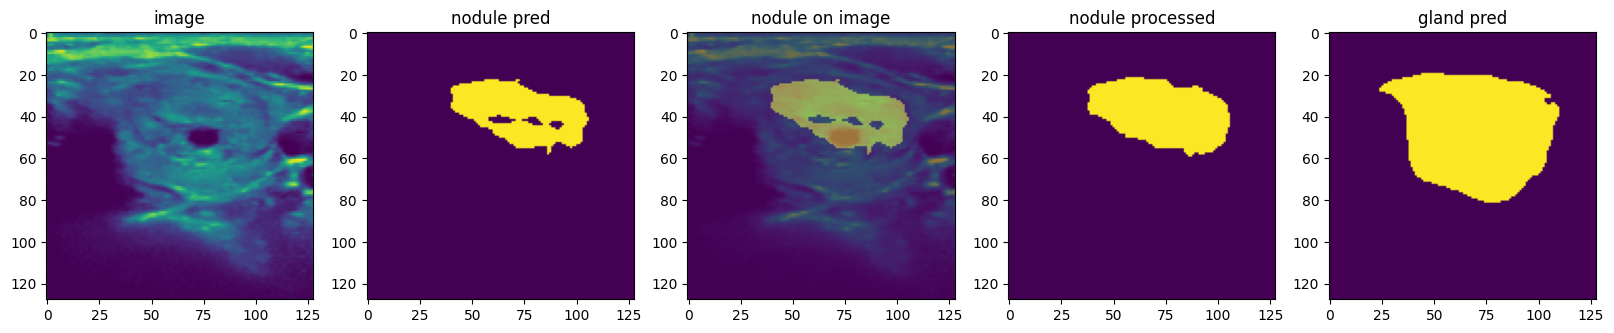

video_000041_1734078135266.MP4/85.png


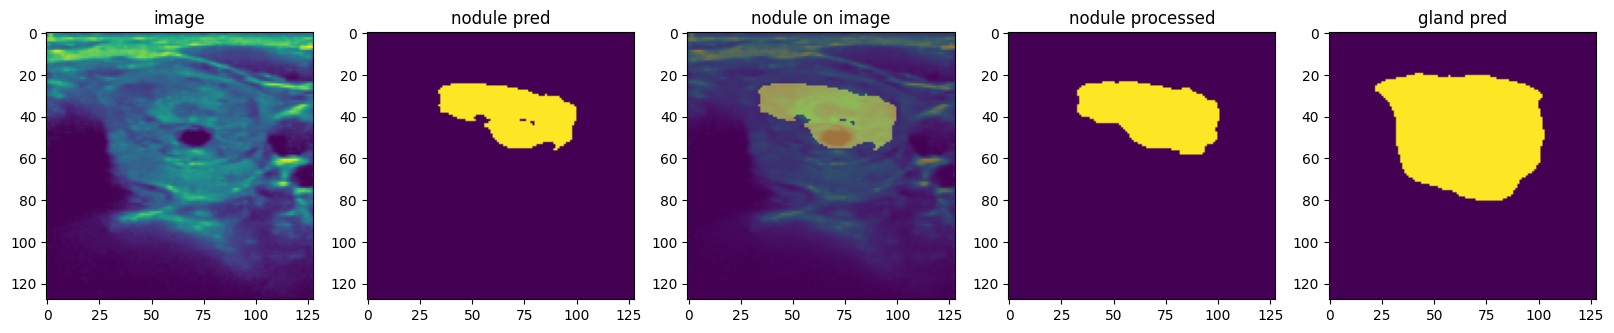

video_000041_1734078135266.MP4/90.png


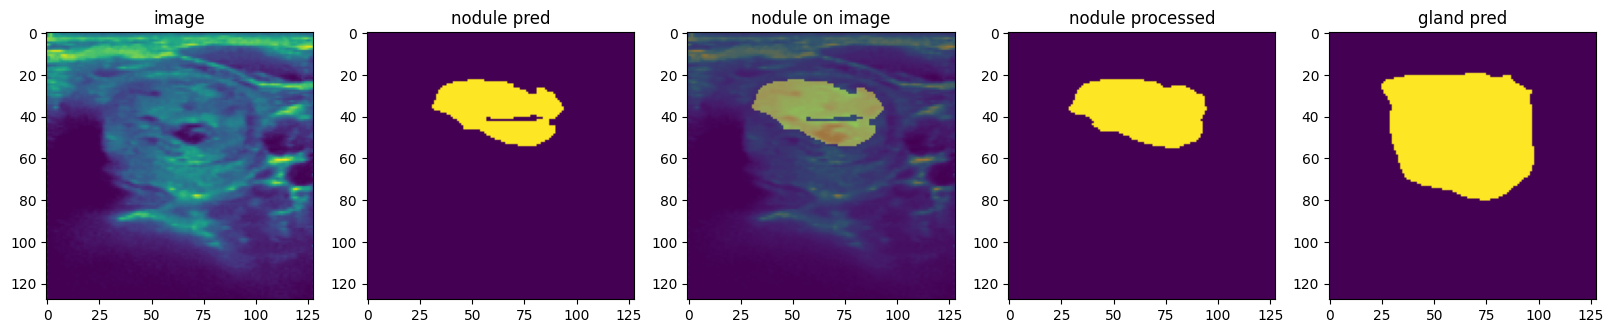

video_000041_1734078135266.MP4/95.png


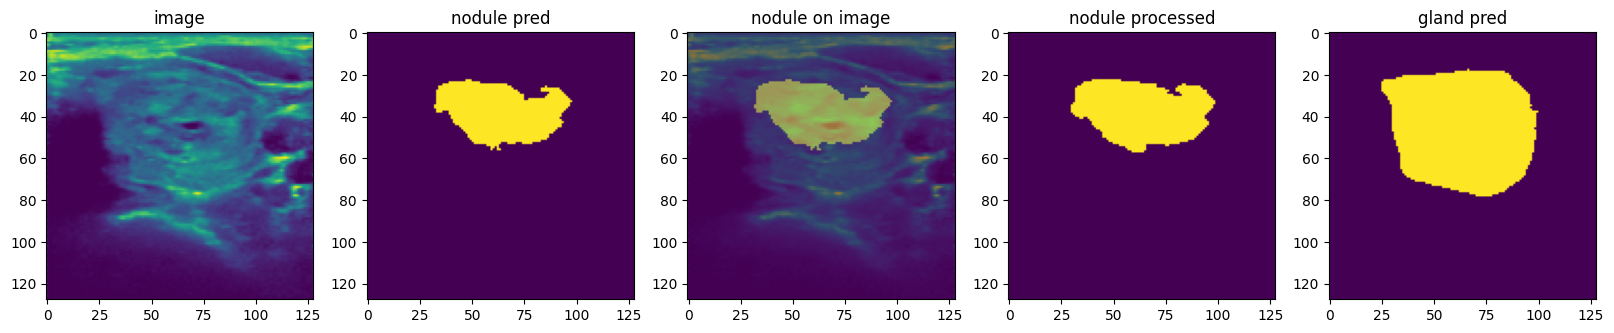

video_000041_1734078135266.MP4/100.png


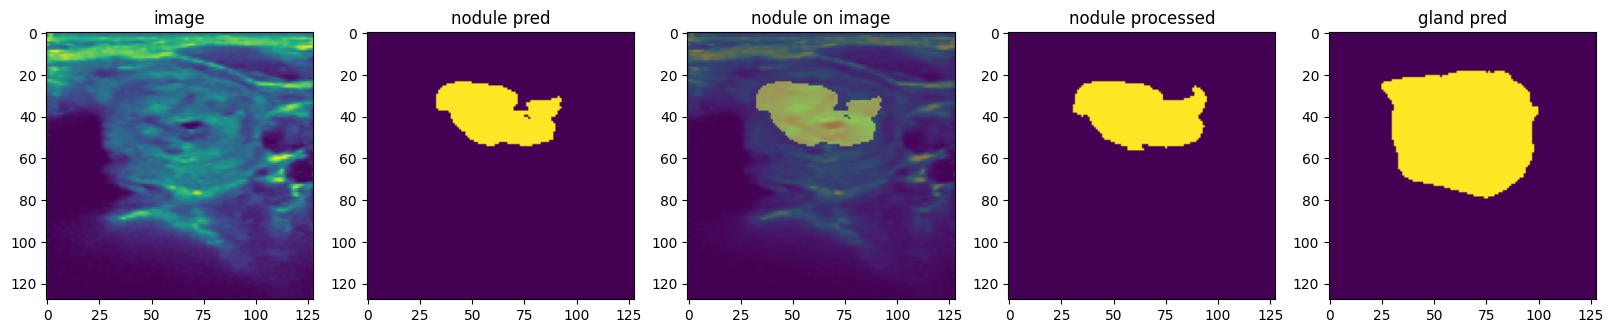

video_000041_1734078135266.MP4/105.png


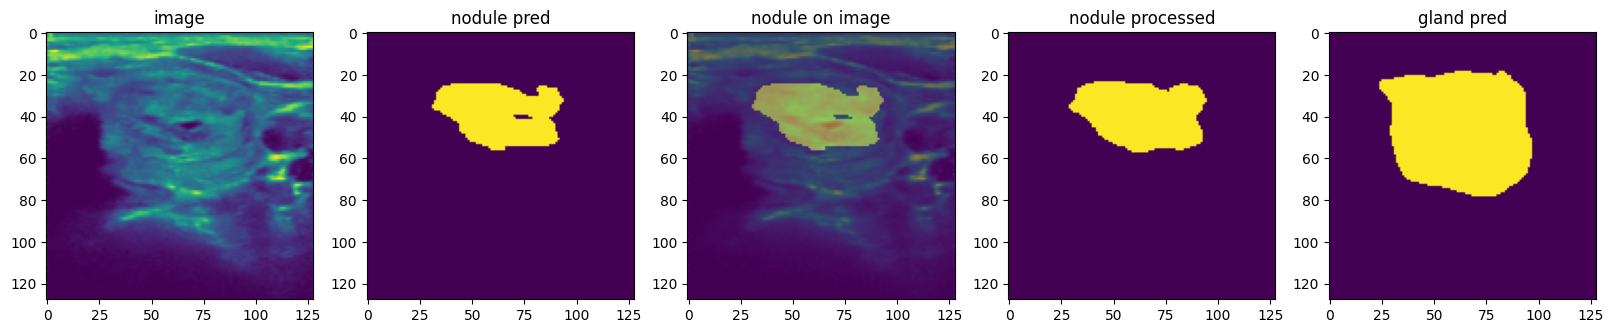

video_000041_1734078135266.MP4/110.png


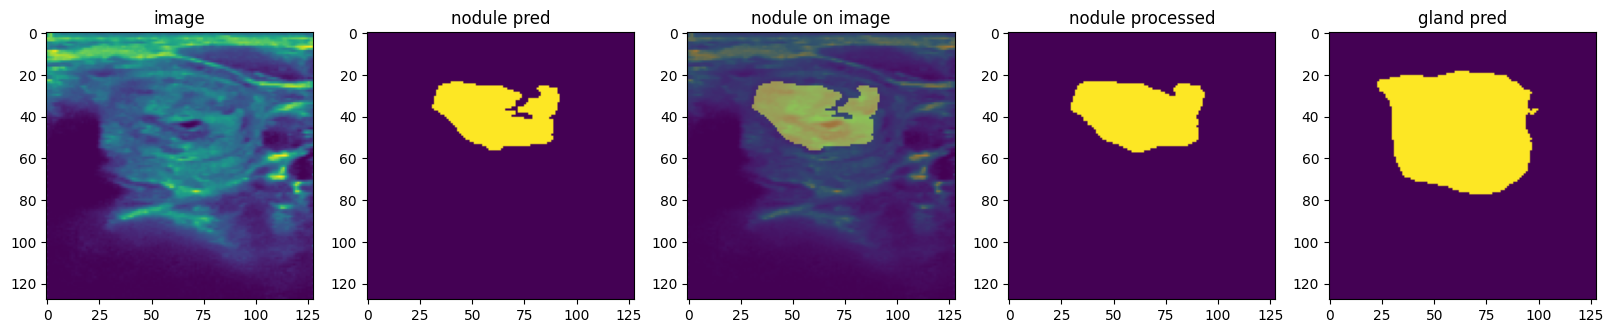

video_000041_1734078135266.MP4/115.png


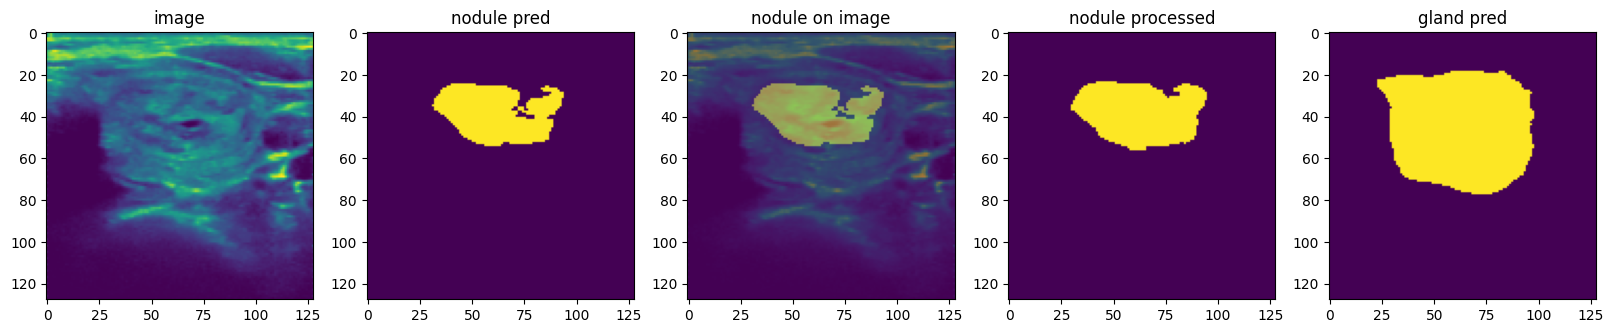

video_000041_1734078135266.MP4/120.png


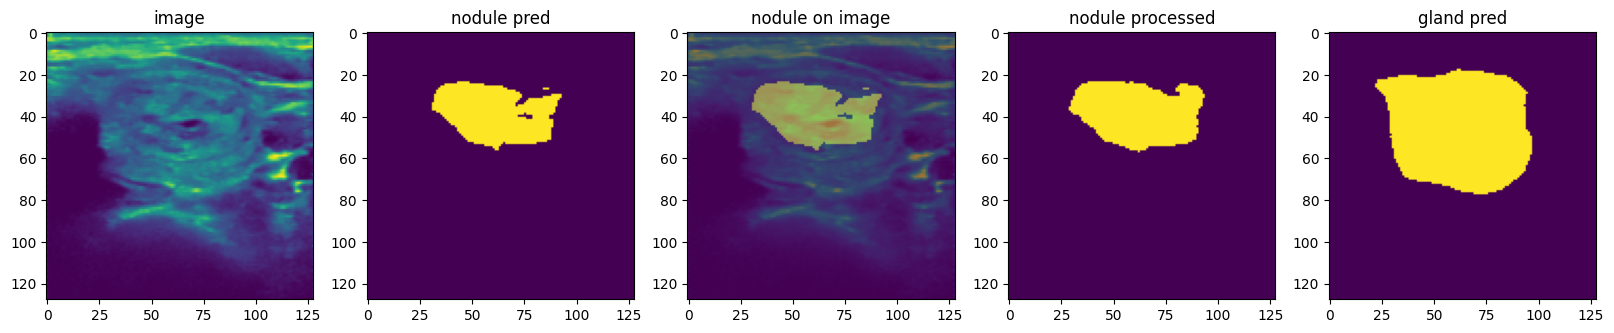

video_000041_1734078135266.MP4/125.png


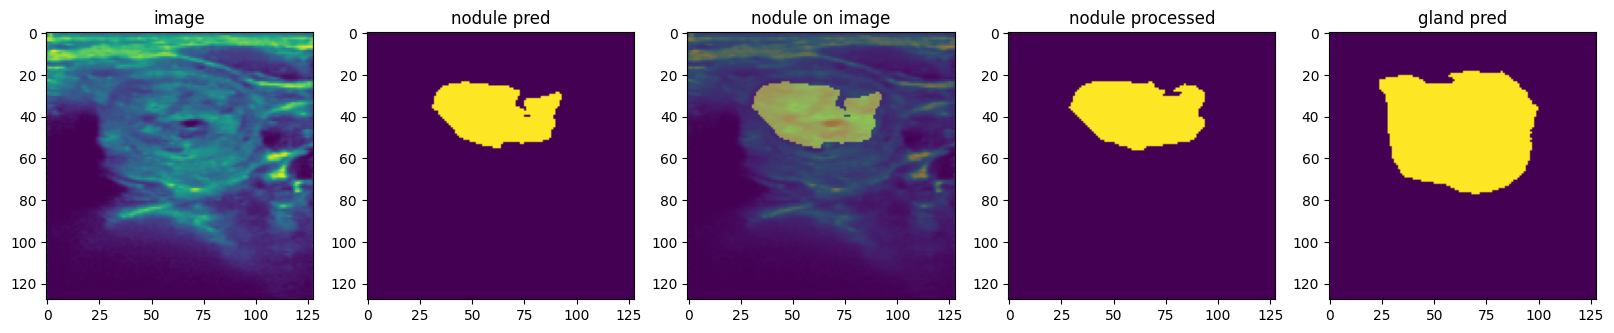

video_000041_1734078135266.MP4/130.png


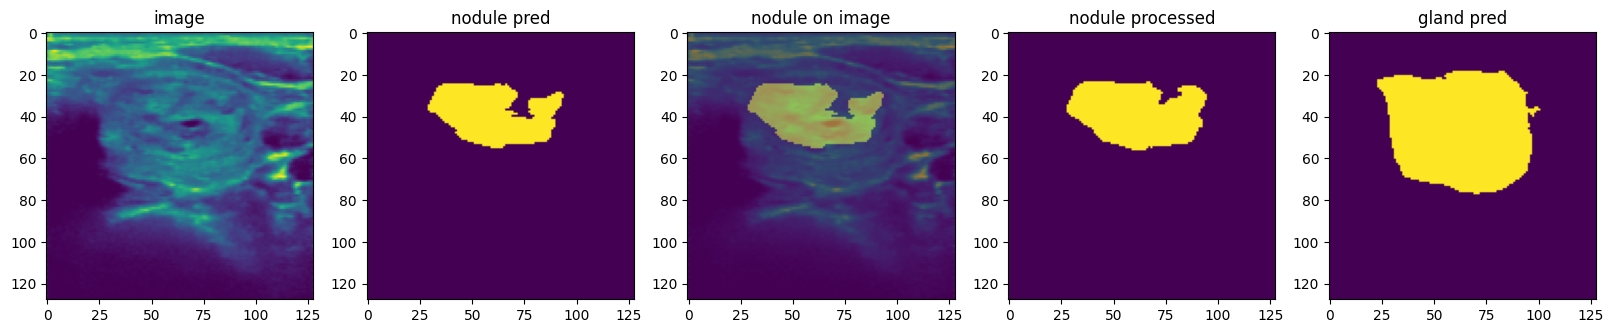

video_000041_1734078135266.MP4/135.png


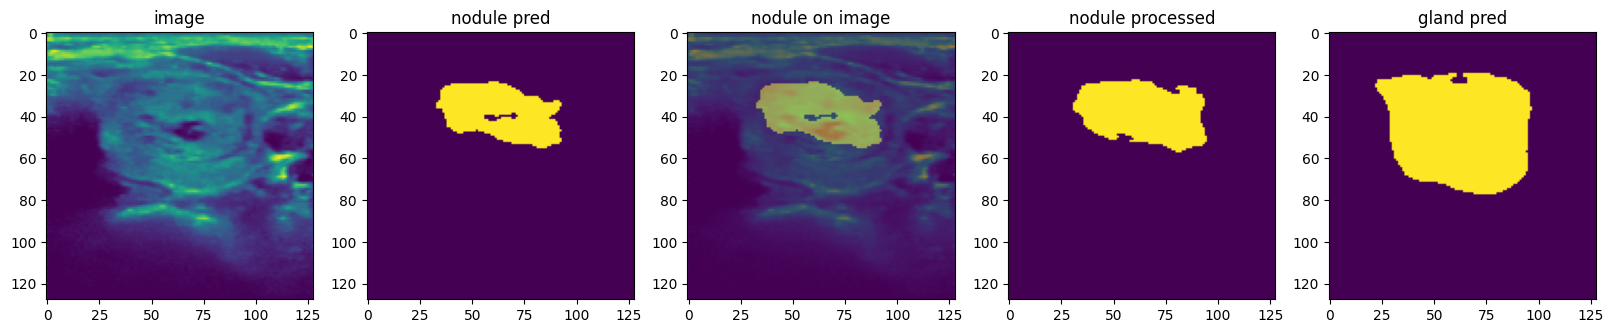

video_000041_1734078135266.MP4/140.png


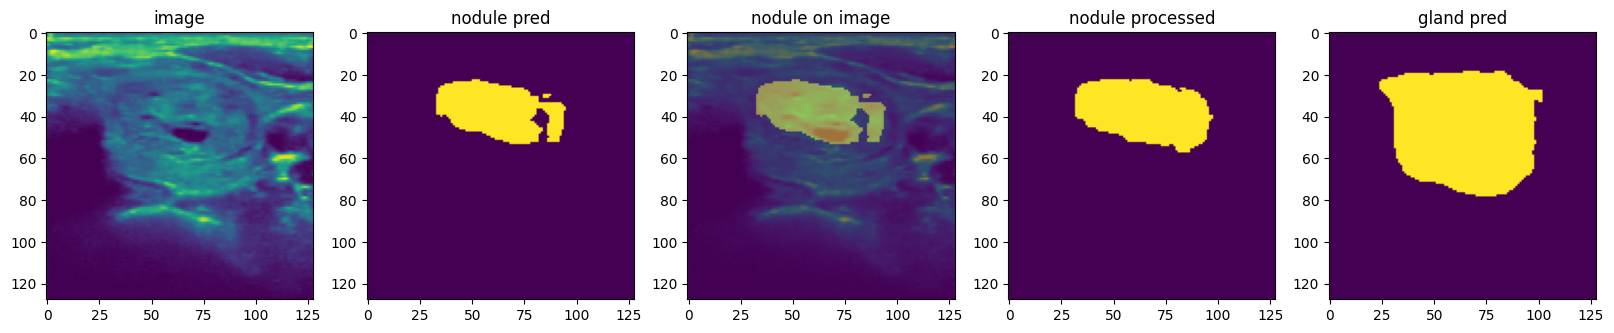

video_000041_1734078135266.MP4/145.png


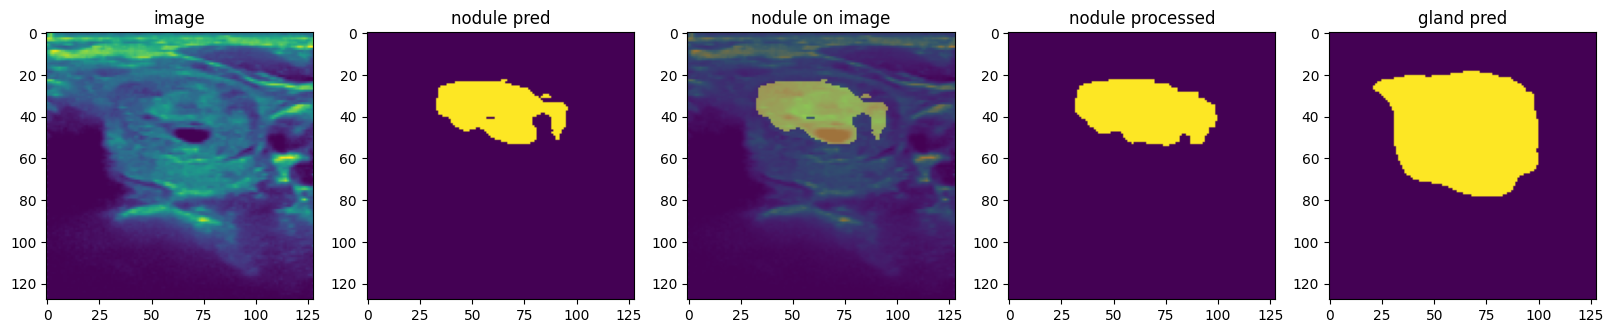

video_000041_1734078135266.MP4/150.png


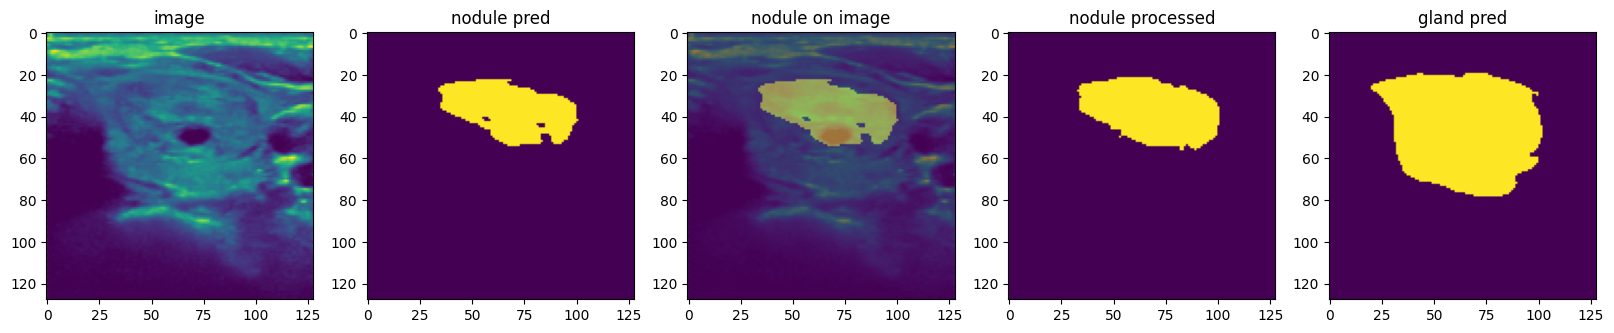

video_000041_1734078135266.MP4/155.png


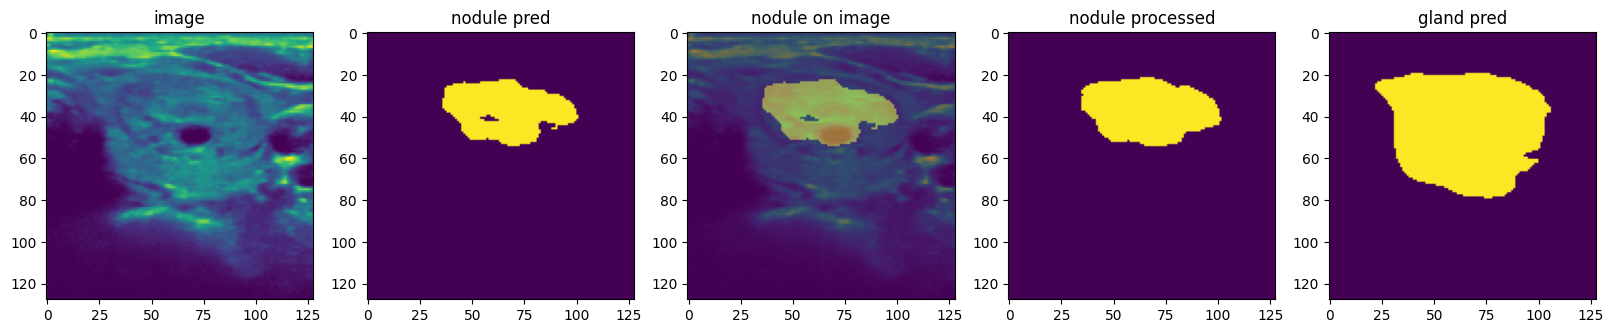

video_000041_1734078135266.MP4/160.png


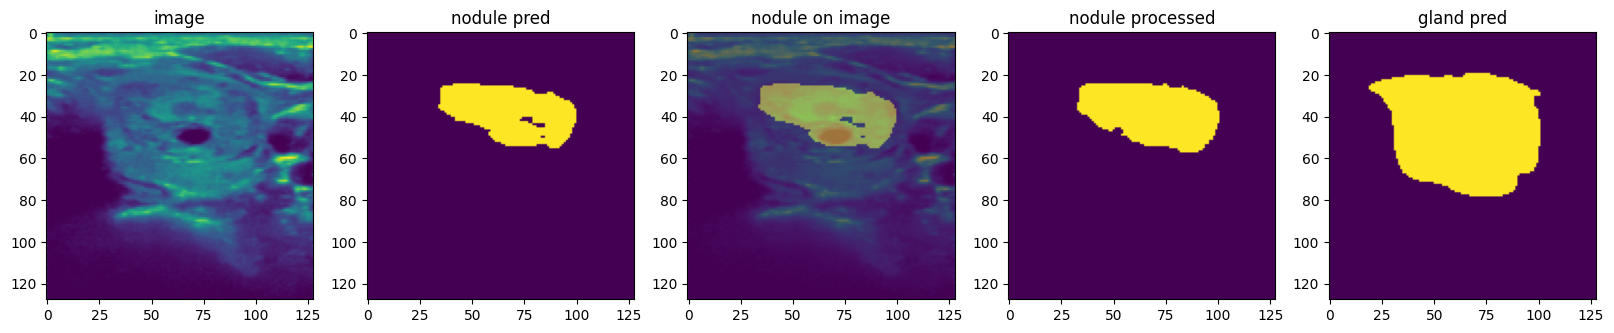

video_000041_1734078135266.MP4/165.png


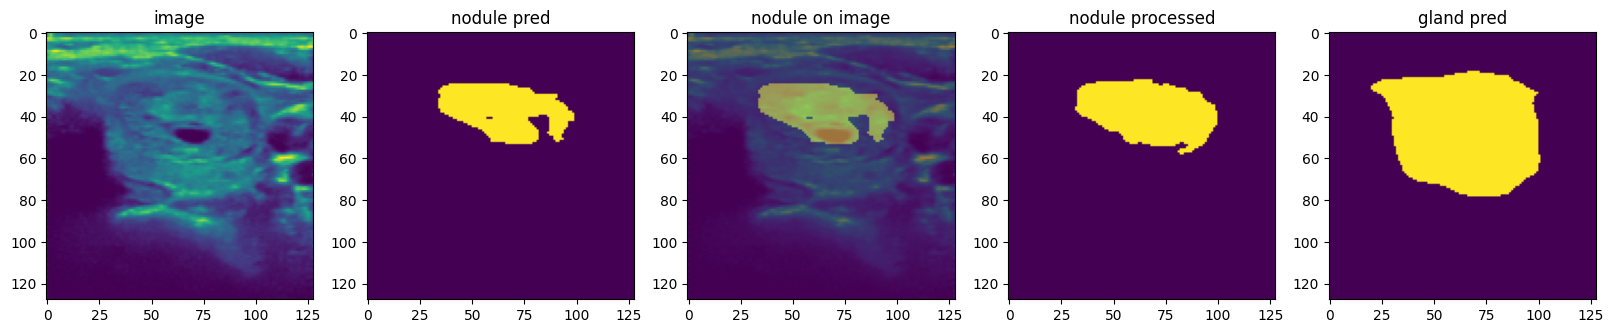

video_000041_1734078135266.MP4/170.png


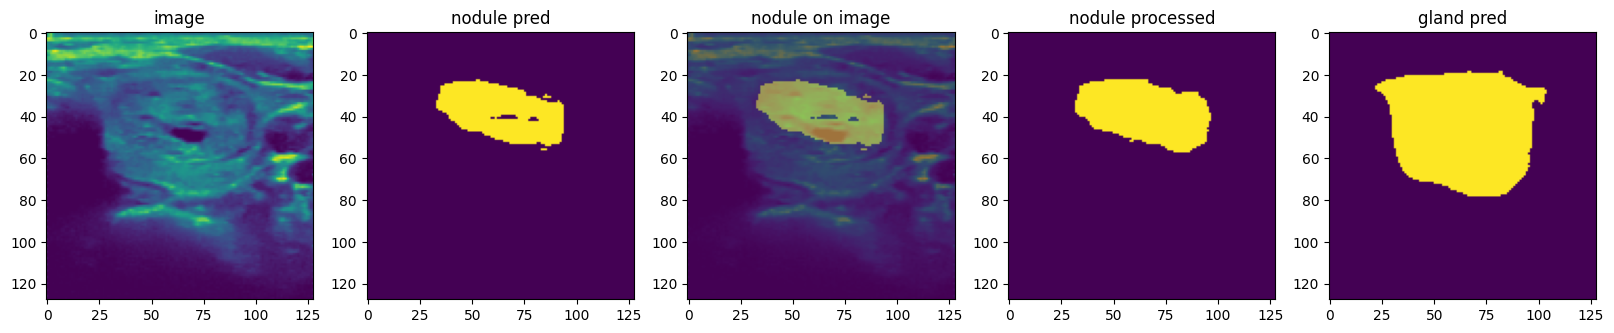

video_000041_1734078135266.MP4/175.png


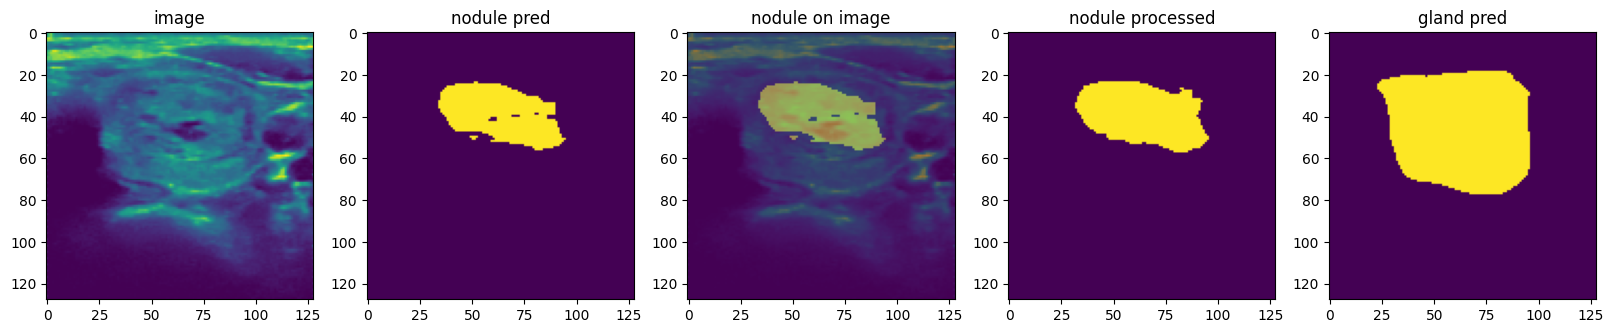

video_000041_1734078135266.MP4/180.png


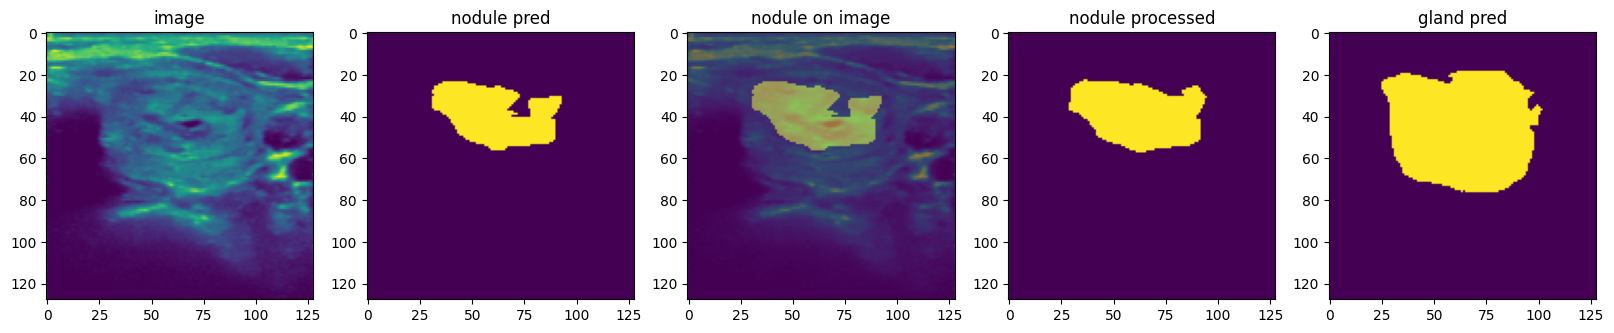

video_000041_1734078135266.MP4/185.png


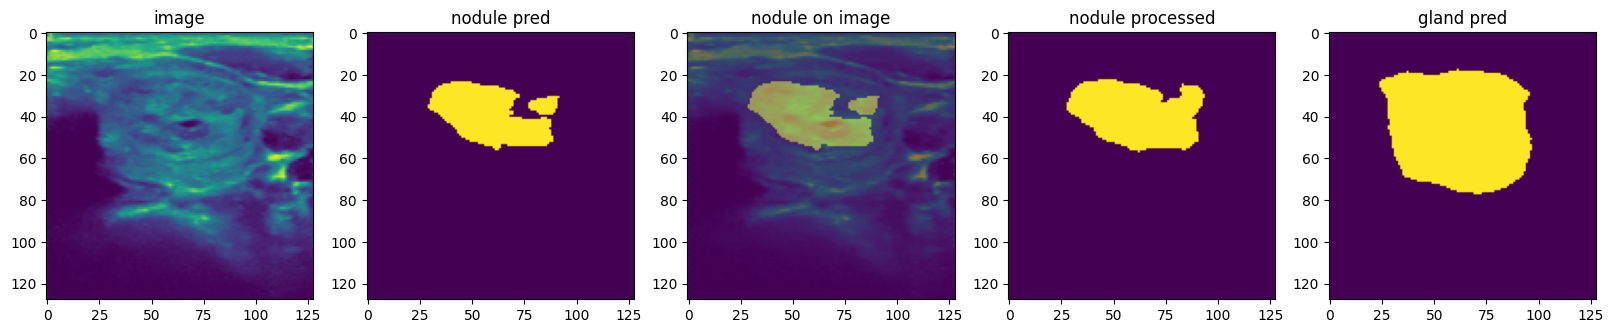

In [10]:
data_root = "crop_images"
video_name = "video_000041_1734078135266.MP4"
print(video_name)
image_dir = sorted(os.listdir(f"{data_root}/{video_name}"))
image_dir = sorted(image_dir, key=lambda x: int(x.split('.')[0]))
print(len(image_dir))
count = 0

for i in (range(len(image_dir))):
    image_name = image_dir[i]
    if not "png" in image_name:
        continue
    image_path = f"{data_root}/{video_name}/{image_name}"
    image = Image.open(image_path).convert("L")

    resize = T.Resize((image_size, image_size))
    image = resize(image)

    image_tensor = tx.to_tensor(image)
    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    image = image_tensor.unsqueeze(0)
    image = image.to("cuda")
    output = model(image)
    
    nodule_output = output[:, 0:1]
    gland_output = output[:, 1:2]

    # nodule_output = torch.sigmoid(nodule_output)
    nodule_process = postprocess_logits_with_fill(nodule_output, 0.9)
    
    nodule_output = torch.sigmoid(nodule_output)
    nodule_output = nodule_output > 0.99

    gland_output = postprocess_logits_with_fill(gland_output, 0.9)
    gland_output = gland_output > 0.99
    
    # print(gland_output.shape)

    nodule_image = Image.fromarray(nodule_output[0][0].detach().cpu().numpy())
    gland_image = Image.fromarray(gland_output[0][0].detach().cpu().numpy())
    
    
    folder_name = "inference_mask_from_scratch_v2_aug_space(0.9)_weight_decay(1e-5)"
    video_path = f"{folder_name}/{video_name}/"
    nodule_path = f"{folder_name}/{video_name}/nodule/"
    gland_path = f"{folder_name}/{video_name}/gland/"
    combine_nodule_path = f"{folder_name}/{video_name}/combine_nodule/"
    combine_gland_path = f"{folder_name}/{video_name}/combine_gland/"
    
    # if not os.path.exists(nodule_path):
    os.makedirs(video_path, exist_ok=True)
    os.makedirs(nodule_path, exist_ok=True)
    os.makedirs(gland_path, exist_ok=True)
    os.makedirs(combine_nodule_path, exist_ok=True)
    os.makedirs(combine_gland_path, exist_ok=True)
        
    nodule_image.save(nodule_path + image_name)
    gland_image.save(gland_path + image_name)

    plt.imshow(image[0][0].detach().cpu().numpy())
    plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.3)
    plt.axis('off')
    plt.savefig(f"{combine_nodule_path}/{image_name}", bbox_inches='tight', pad_inches=0)
    # plt.show()
    plt.close()

    plt.imshow(image[0][0].detach().cpu().numpy())
    plt.imshow(gland_output[0][0].detach().cpu().numpy(), alpha = 0.3)
    plt.axis('off')
    plt.savefig(f"{combine_gland_path}/{image_name}", bbox_inches='tight', pad_inches=0)
    # plt.show()
    plt.close()
    # break
    if count%5 == 0:
        print(video_name + "/" + image_name)
        plt.figure(figsize = (20, 20))
        plt.subplot(1,5,1)
        plt.imshow(image[0][0].detach().cpu().numpy())
        plt.title("image")
        plt.subplot(1,5,2)
        plt.imshow(nodule_output[0][0].detach().cpu().numpy())
        plt.title("nodule pred")
        
        plt.subplot(1,5,3)
        plt.imshow(image[0][0].detach().cpu().numpy())
        plt.imshow(nodule_output[0][0].detach().cpu().numpy(), alpha = 0.5)
        plt.title("nodule on image")
        
        plt.subplot(1,5,4)
        plt.imshow(nodule_process[0][0].detach().cpu().numpy())
        plt.title("nodule processed")
        plt.subplot(1,5,5)
        plt.imshow(gland_output[0][0].detach().cpu().numpy())
        plt.title("gland pred")
        plt.show()
    count+=1
    # if count > 30:
    #     break
    


In [9]:

data_root = "crop_images"
video_name = "video_000041_1734078135266.MP4"
image_dir = sorted(os.listdir(f"{data_root}/{video_name}"))
image_dir = sorted(image_dir, key=lambda x: int(x.split('.')[0]))
print((image_dir))

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png'